In [1]:
#Imports

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

from pandas import Series,DataFrame
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
def convert_sex(val):
    if val == 'male': return 1
    else: return 0
    
def read_data(file):
    return pd.read_csv(file, sep=',', converters = {'Sex': convert_sex})

#Read in CSVs
train_data = read_data('train.csv')
test_data = read_data('test.csv')

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


In [3]:
#Print info on dataframes extracted from csv files for train/test
train_data.info()
print("----------------------------")
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int64
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(6), object(4)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int64
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare  

In [4]:
#Remove initial unwanted columns, useless in prediction
train_data = train_data.drop(['PassengerId','Name','Ticket'], axis=1)
test_data  = test_data.drop(['Name','Ticket'], axis=1)

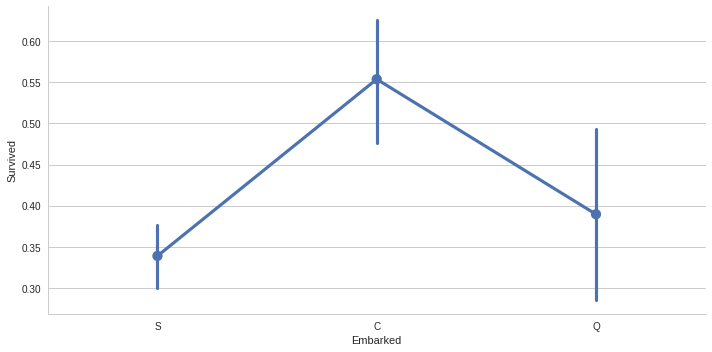

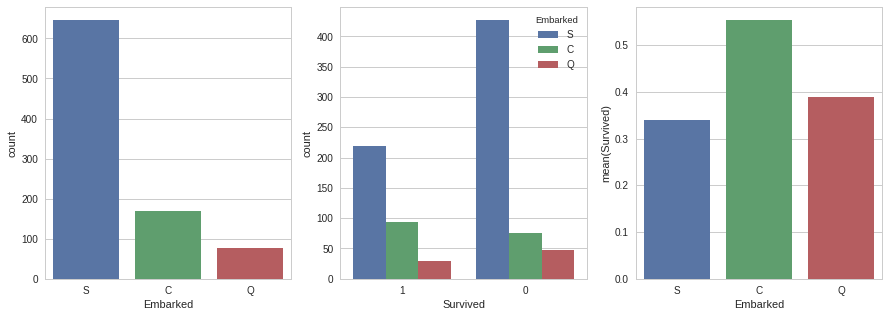

In [5]:
#Embarked

#Fill NaN entries with S,  as a place holder
train_data["Embarked"] = train_data["Embarked"].fillna("S")

#Plot 
sns.factorplot('Embarked','Survived', data=train_data,size=5,aspect=2)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

sns.countplot(x='Embarked', data=train_data, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=train_data, order=[1,0], ax=axis2)

#Group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = train_data[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

#Embarked doesn't appear to be super useful in prediction
train_data.drop(['Embarked'], axis=1,inplace=True)
test_data.drop(['Embarked'], axis=1,inplace=True)



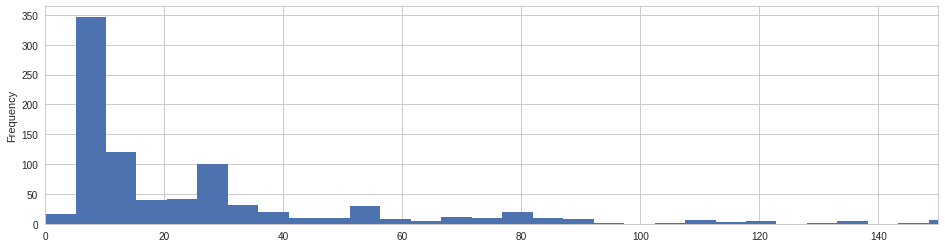

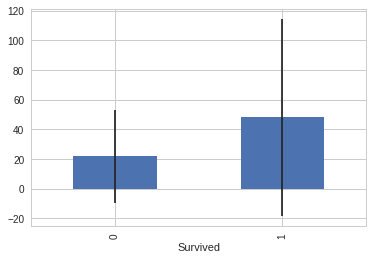

In [6]:
#Fare 

#Only for test_data, since there is a missing "Fare" values
test_data["Fare"].fillna(test_data["Fare"].median(), inplace=True)

#Convert from float to int,  this will make it simpler to plot
train_data['Fare'] = train_data['Fare'].astype(int)
test_data['Fare'] = test_data['Fare'].astype(int)

#Fare for survivors and non-survivors
fare_not_survived = train_data["Fare"][train_data["Survived"] == 0]
fare_survived = train_data["Fare"][train_data["Survived"] == 1]

#Average and std for fare of survivors and non-survivors
avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = DataFrame([fare_not_survived.std(), fare_survived.std()])

#Plot
train_data['Fare'].plot(kind='hist', figsize=(16,4),bins=100, xlim=(0,150))

avgerage_fare.index.names = std_fare.index.names = ["Survived"]
avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False)

/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


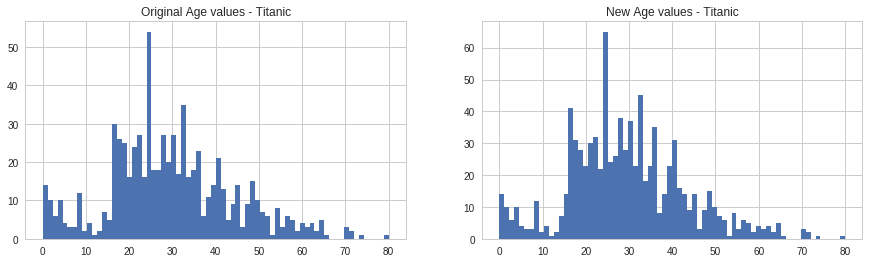

In [7]:
#Age

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

#Get average, std, and number of NaN values in train_data
average_age_train = train_data["Age"].mean()
std_age_train = train_data["Age"].std()
count_nan_age_train = train_data["Age"].isnull().sum()

#Get average, std, and number of NaN values in test_data
average_age_test = test_data["Age"].mean()
std_age_test = test_data["Age"].std()
count_nan_age_test = test_data["Age"].isnull().sum()

#Generate random numbers between (mean - std) & (mean + std)
rand_1 = np.random.randint(average_age_train - std_age_train, average_age_train + std_age_train, size = count_nan_age_train)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

#Plot original Age values
#NOTE: drop all null values, and convert to int
train_data['Age'].dropna().astype(int).hist(bins=70, ax=axis1)

# fill NaN values in Age column with random values generated
train_data["Age"][np.isnan(train_data["Age"])] = rand_1
test_data["Age"][np.isnan(test_data["Age"])] = rand_2

# convert from float to int
train_data['Age'] = train_data['Age'].astype(int)
test_data['Age'] = test_data['Age'].astype(int)
        
# plot new Age Values
train_data['Age'].hist(bins=70, ax=axis2)

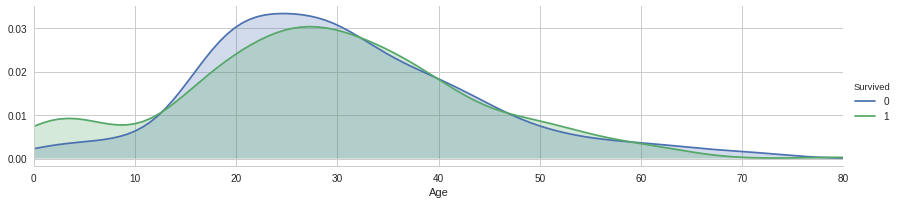

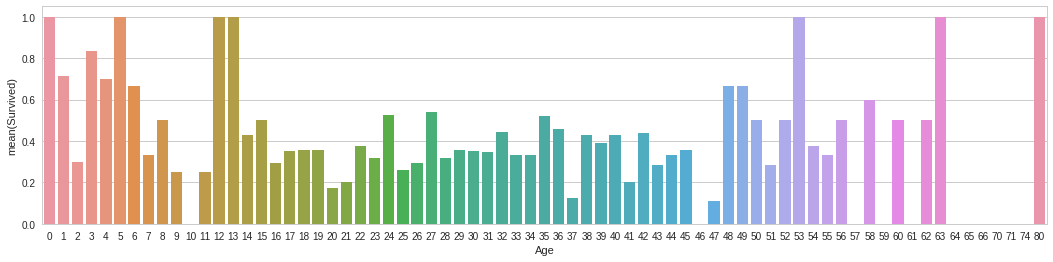

In [8]:
#Peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(train_data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_data['Age'].max()))
facet.add_legend()

# Average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = train_data[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

In [9]:
#Cabin

#It has a lot of NaN values, so it won't cause a remarkable impact on prediction
train_data.drop("Cabin",axis=1,inplace=True)
test_data.drop("Cabin",axis=1,inplace=True)

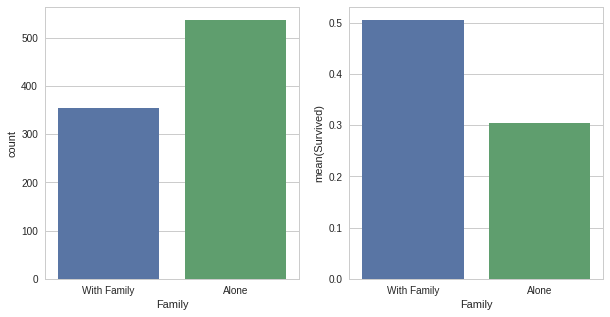

In [10]:
#Family

#Compress Parch and SibSp into a single binary column representing existence of family members.
train_data['Family'] = train_data["Parch"] + train_data["SibSp"]
train_data['Family'].loc[train_data['Family'] > 0] = 1
train_data['Family'].loc[train_data['Family'] == 0] = 0

test_data['Family'] = test_data["Parch"] + test_data["SibSp"]
test_data['Family'].loc[test_data['Family'] > 0] = 1
test_data['Family'].loc[test_data['Family'] == 0] = 0

#Drop Parch and SibSp
train_data = train_data.drop(['SibSp','Parch'], axis=1)
test_data = test_data.drop(['SibSp','Parch'], axis=1)

#Plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

sns.countplot(x='Family', data=train_data, order=[1,0], ax=axis1)

#Average of survived for those who had/didn't have any family member
family_perc = train_data[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["With Family","Alone"], rotation=0)

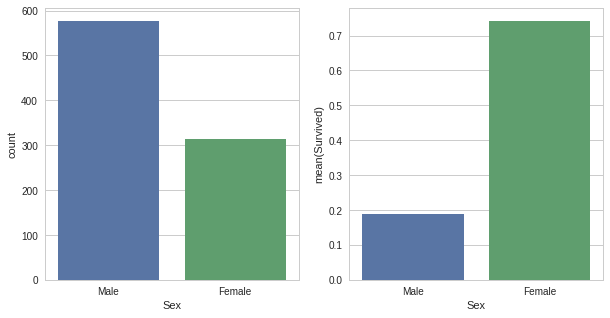

In [11]:
#Sex

#Plot
fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

sns.countplot(x='Sex', data=train_data, order=[1,0], ax=axis1)

#Average of survived for those who had/didn't have any family member
sex_perc = train_data[["Sex", "Survived"]].groupby(['Sex'],as_index=False).mean()
sns.barplot(x='Sex', y='Survived', data=sex_perc, order=[1,0], ax=axis2)

axis1.set_xticklabels(["Male","Female"], rotation=0)

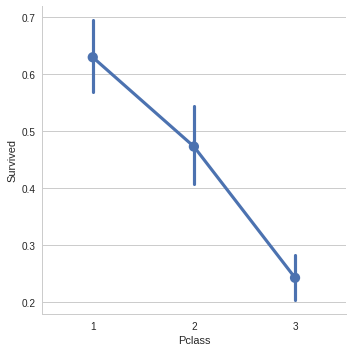

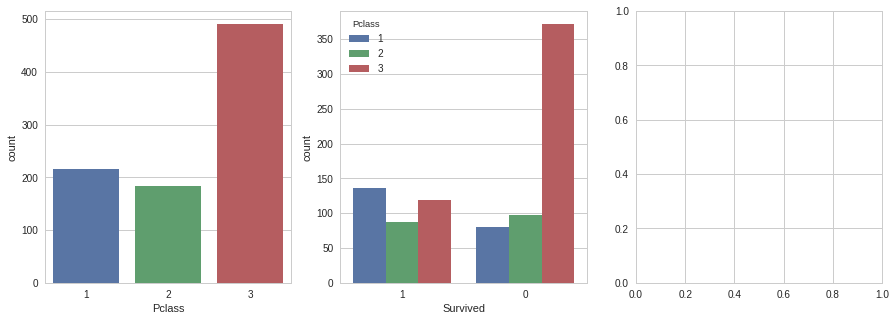

In [12]:
#Pclass

sns.factorplot('Pclass','Survived',order=[1,2,3], data=train_data,size=5)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))

sns.countplot(x='Pclass', data=train_data, ax=axis1)
sns.countplot(x='Survived', hue="Pclass", data=train_data, order=[1,0], ax=axis2)

# create dummy variables for Pclass column, & drop 3rd class as it has the lowest average of survived passengers
#pclass_dummies_titanic  = pd.get_dummies(train_data['Pclass'])
#pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']

#pclass_dummies_test  = pd.get_dummies(test_data['Pclass'])
#pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']

#sns.barplot(x='Pclass', y='Survived', data=pclass_dummies_titanic ,order=['1','2','3'],ax=axis3)

#titanic_df.drop(['Pclass'],axis=1,inplace=True)
#test_df.drop(['Pclass'],axis=1,inplace=True)

#titanic_df = titanic_df.join(pclass_dummies_titanic)
#test_df    = test_df.join(pclass_dummies_test)


In [13]:
#Remove unwanted columns
#train_data = train_data.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis = 1)
#test_data = test_data.drop(['Name', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis = 1)

#Remove NaN rows
#train_data = train_data.dropna()
#test_data = test_data.dropna()

#Retrieve passengerId to build output
test_passenger_data = test_data['PassengerId']

test_data = test_data.drop('PassengerId', axis = 1)

print(test_data.shape[0])
print(test_data)


418
     Pclass  Sex  Age  Fare  Family
0         3    1   34     7       0
1         3    0   47     7       1
2         2    1   62     9       0
3         3    1   27     8       0
4         3    0   22    12       1
5         3    1   14     9       0
6         3    0   30     7       0
7         2    1   26    29       1
8         3    0   18     7       0
9         3    1   21    24       1
10        3    1   39     7       0
11        1    1   46    26       0
12        1    0   23    82       1
13        2    1   63    26       1
14        1    0   47    61       1
15        2    0   24    27       1
16        2    1   35    12       0
17        3    1   21     7       0
18        3    0   27     7       1
19        3    0   45     7       0
20        1    1   55    59       1
21        3    1    9     3       1
22        1    0   22    31       0
23        1    1   21    61       1
24        1    0   48   262       1
25        3    1   50    14       1
26        1    0   22   

In [14]:
#Split datasets into training data(X),  and classifier(y)
train_y = train_data['Survived']
train_X = train_data.drop("Survived", axis=1)
test_X = test_data


In [15]:
#Naive Bayes
gnb = GaussianNB()
gnb.fit(train_X, train_y)

train_y_pred = gnb.predict(train_X)
test_y_pred = gnb.predict(test_X)

#Compare acccuracy of prediction
#print(metrics.accuracy_score(train_y, train_y_pred))
print(gnb.score(train_X, train_y))

0.771043771044


In [16]:
#Logistic Regression
lr = LogisticRegression()
lr.fit(train_X, train_y)

train_y_pred = lr.predict(train_X)
test_y_pred = lr.predict(test_X)

#Compare acccuracy of prediction
#print(metrics.accuracy_score(train_y, train_y_pred))
print(lr.score(train_X, train_y))

0.79012345679


In [17]:
#SVC
svc = SVC()
svc.fit(train_X, train_y)

train_y_pred = svc.predict(train_X)
test_y_pred = svc.predict(test_X)

#Compare acccuracy of prediction
#print(metrics.accuracy_score(train_y, train_y_pred))
print(svc.score(train_X, train_y))

0.901234567901


In [18]:
#K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(train_X, train_y)

train_y_pred = knn.predict(train_X)
test_y_pred = knn.predict(test_X)

#Compare acccuracy of prediction
#print(metrics.accuracy_score(train_y, train_y_pred))
print(knn.score(train_X, train_y))

0.832772166105


In [24]:
#RandomForest
rf = RandomForestClassifier(n_estimators=10000)
rf.fit(train_X, train_y)

train_y_pred = rf.predict(train_X)
test_y_pred = rf.predict(test_X)

#Compare acccuracy of prediction
#print(metrics.accuracy_score(train_y, train_y_pred))
print(rf.score(train_X, train_y))

0.956228956229


In [20]:
submission = pd.DataFrame({
        "PassengerId": test_passenger_data ,
        "Survived": test_y_pred
    })
submission.to_csv('titanic.csv', index=False)